Train set: {'NORMAL': 1349, 'PNEUMONIA': 3884}
Test set: {'NORMAL': 234, 'PNEUMONIA': 390}


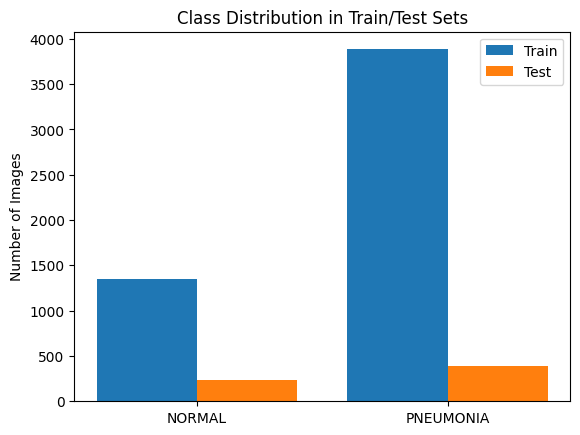

In [2]:
import os
import matplotlib.pyplot as plt

train_dir = 'train'
test_dir = 'test'

def count_images(directory):
    class_counts = {}
    for label in os.listdir(directory):
        class_path = os.path.join(directory, label)
        if os.path.isdir(class_path):
            class_counts[label] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

print("Train set:", train_counts)
print("Test set:", test_counts)

# Visualize the distribution
labels = list(train_counts.keys())
train_values = list(train_counts.values())
test_values = list(test_counts.values())

x = range(len(labels))
plt.bar(x, train_values, width=0.4, label='Train', align='center')
plt.bar([i + 0.4 for i in x], test_values, width=0.4, label='Test', align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.title("Class Distribution in Train/Test Sets")
plt.ylabel("Number of Images")
plt.legend()
plt.show()


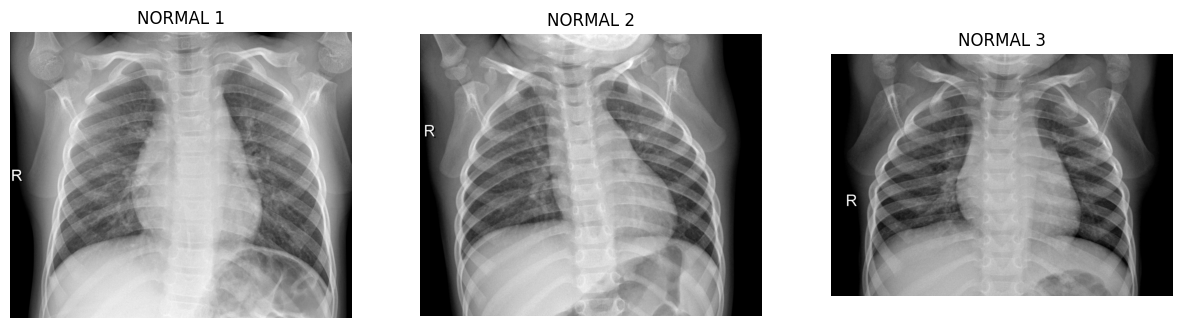

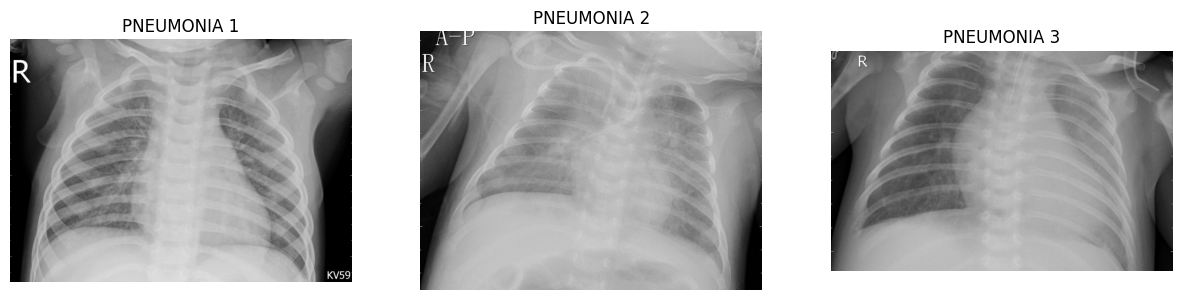

In [3]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_random_images(folder_path, title, n=3):
    images = os.listdir(folder_path)
    selected = random.sample(images, n)
    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(selected):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

# Show samples from both classes
show_random_images(os.path.join(train_dir, "NORMAL"), "NORMAL")
show_random_images(os.path.join(train_dir, "PNEUMONIA"), "PNEUMONIA")


In [4]:
from PIL import Image

def check_image_shapes(directory):
    shapes = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.jpeg') or file.endswith('.jpg') or file.endswith('.png'):
                    img_path = os.path.join(folder_path, file)
                    try:
                        img = Image.open(img_path)
                        shapes[img.size] = shapes.get(img.size, 0) + 1
                    except:
                        print(f"Error loading: {img_path}")
    return shapes

shape_counts = check_image_shapes(train_dir)
print("Image dimension frequencies in training set:")
for shape, count in shape_counts.items():
    print(f"{shape}: {count} images")


Image dimension frequencies in training set:
(2090, 1858): 1 images
(1422, 1152): 1 images
(1810, 1434): 1 images
(1618, 1279): 1 images
(1600, 1125): 1 images
(1974, 1306): 1 images
(1528, 1013): 1 images
(1384, 1167): 1 images
(1450, 1144): 1 images
(1468, 993): 1 images
(1724, 1581): 1 images
(1346, 1044): 1 images
(1156, 1237): 1 images
(1740, 1453): 1 images
(2138, 1928): 1 images
(1596, 1156): 1 images
(2102, 1974): 1 images
(1542, 1152): 1 images
(1518, 1156): 1 images
(1612, 1133): 1 images
(1844, 1438): 1 images
(1488, 1209): 1 images
(994, 758): 1 images
(1750, 1314): 1 images
(1762, 1430): 1 images
(1202, 808): 1 images
(1972, 1719): 1 images
(1534, 1187): 1 images
(2148, 1496): 1 images
(1876, 1893): 1 images
(1680, 1557): 1 images
(2172, 1615): 1 images
(1646, 1124): 1 images
(2136, 1650): 1 images
(1372, 1005): 1 images
(2338, 2025): 1 images
(1458, 1190): 1 images
(1854, 1572): 1 images
(1466, 1109): 1 images
(2164, 1746): 1 images
(2010, 1747): 1 images
(1774, 1546): 1 

C:\Users\Sai babu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129518 (\N{ABACUS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


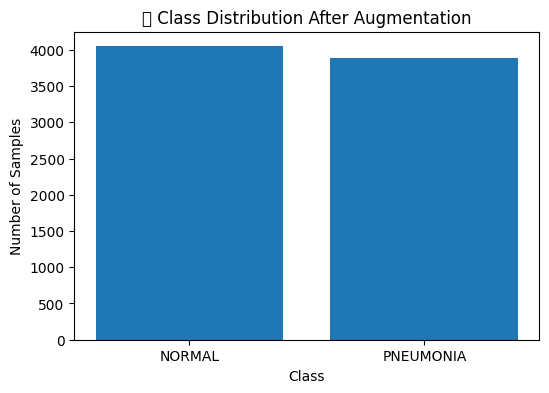

✅ Setup complete: Weighted Loss + Manual Augmentation + Oversampling + Balance Check Plot


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler, ConcatDataset
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== 1. Define Transforms ========
base_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

augment_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

# ======== 2. Load Base Dataset ========
data_dir = 'train'  # TODO: replace with your path
base_dataset = datasets.ImageFolder(root=data_dir, transform=base_transforms)
class_names = base_dataset.classes
class_to_idx = base_dataset.class_to_idx

# ======== 3. Manually Augment Underrepresented Class (e.g. "NORMAL") ========
minority_class = 'NORMAL'
minority_class_idx = class_to_idx[minority_class]

aug_dataset = datasets.ImageFolder(root=data_dir, transform=augment_transforms)
aug_dataset.samples = [s for s in aug_dataset.samples if s[1] == minority_class_idx]
aug_dataset.samples *= 2  # Can tweak for more balance

# ======== 4. Combine Base + Augmented Dataset ========
full_dataset = ConcatDataset([base_dataset, aug_dataset])

# ======== 5. Calculate Class Distribution for Sampling & Plot ========
targets = [label for _, label in full_dataset]
class_counts = Counter(targets)
total = sum(class_counts.values())

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("🧮 Class Distribution After Augmentation")
plt.show()

# ======== 6. Weighted Sampler for Oversampling ========
class_weights = 1. / torch.tensor([class_counts[t] for t in targets], dtype=torch.float)
sample_weights = torch.tensor([class_weights[t] for t in targets])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# ======== 7. Dataloader ========
train_loader = DataLoader(full_dataset, batch_size=32, sampler=sampler)

# ======== 8. Weighted CrossEntropy Loss ========
loss_weights = torch.tensor([total / class_counts[i] for i in range(len(class_names))], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=loss_weights)

print("✅ Setup complete: Weighted Loss + Manual Augmentation + Oversampling + Balance Check Plot")


Epoch 1: 100%|██████████| 248/248 [02:34<00:00,  1.60it/s]


📊 Epoch 1: Train Acc: 0.9264, Val Acc: 0.9716
✅ Best model saved!


Epoch 2: 100%|██████████| 248/248 [02:35<00:00,  1.60it/s]


📊 Epoch 2: Train Acc: 0.9728, Val Acc: 0.9647


Epoch 3: 100%|██████████| 248/248 [02:39<00:00,  1.55it/s]


📊 Epoch 3: Train Acc: 0.9748, Val Acc: 0.9830
✅ Best model saved!


Epoch 4: 100%|██████████| 248/248 [02:37<00:00,  1.58it/s]


📊 Epoch 4: Train Acc: 0.9832, Val Acc: 0.9874
✅ Best model saved!


Epoch 5: 100%|██████████| 248/248 [02:37<00:00,  1.57it/s]


📊 Epoch 5: Train Acc: 0.9892, Val Acc: 0.9931
✅ Best model saved!


Epoch 6: 100%|██████████| 248/248 [02:41<00:00,  1.54it/s]


📊 Epoch 6: Train Acc: 0.9887, Val Acc: 0.9931


Epoch 7: 100%|██████████| 248/248 [02:37<00:00,  1.57it/s]


📊 Epoch 7: Train Acc: 0.9904, Val Acc: 0.9962
✅ Best model saved!


Epoch 8: 100%|██████████| 248/248 [02:38<00:00,  1.56it/s]


📊 Epoch 8: Train Acc: 0.9934, Val Acc: 0.9968
✅ Best model saved!


Epoch 9: 100%|██████████| 248/248 [02:49<00:00,  1.46it/s]


📊 Epoch 9: Train Acc: 0.9958, Val Acc: 0.9968


Epoch 10: 100%|██████████| 248/248 [02:38<00:00,  1.56it/s]


📊 Epoch 10: Train Acc: 0.9941, Val Acc: 0.9968


C:\Users\Sai babu\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


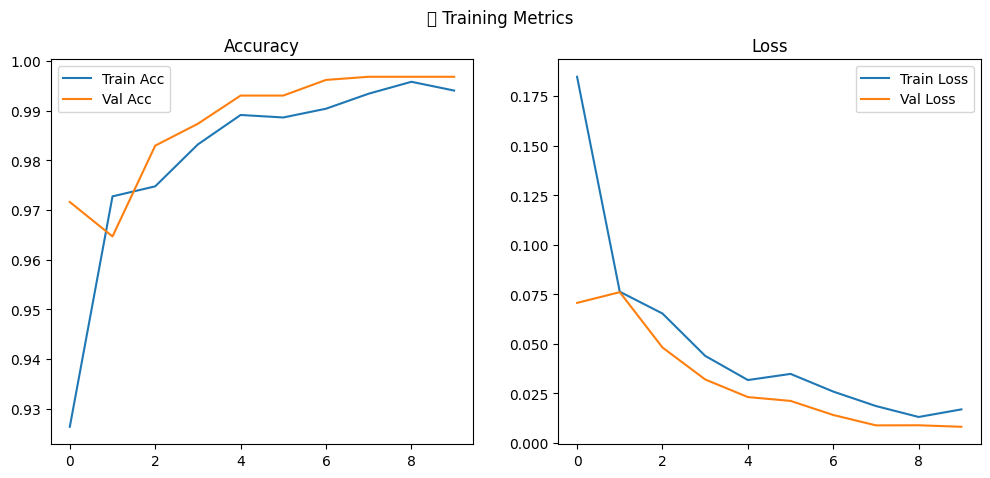

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

# ======== 1. CNN Model ========
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # (B, 3, 224, 224) → (B, 16, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2),                # → (B, 16, 112, 112)

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # → (B, 32, 56, 56)

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # → (B, 64, 28, 28)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ======== 2. Split Dataset into Train/Val ========
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

# ======== 3. Model Setup ========
model = PneumoniaCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

train_accs, val_accs = [], []
train_losses, val_losses = [], []

best_val_acc = 0.0

# ======== 4. Training Loop ========
for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_accs.append(train_acc)
    train_losses.append(total_loss / len(train_loader))

    # ======== 5. Validation ========
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total
    val_accs.append(val_acc)
    val_losses.append(val_loss / len(val_loader))

    print(f"📊 Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")

# ======== 6. Plot Metrics ========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss")
plt.legend()

plt.suptitle("📈 Training Metrics")
plt.show()


C:\Users\Sai babu\AppData\Local\Temp\ipykernel_40276\3407883295.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


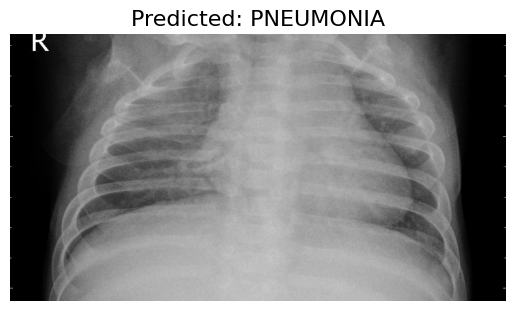

In [11]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt

# ======== 1. Load Saved Model ========
model = PneumoniaCNN().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# ======== 2. Image Preprocessing ========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Mean and std for 3 channels
])

# Load image (change path to your test image)
image_path = "person33_virus_72.jpeg"  # ⬅️ Replace with your image path
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# ======== 3. Predict Class ========
with torch.no_grad():
    output = model(input_tensor)
    pred_class = torch.argmax(output, 1).item()

# ======== 4. Display Result ========
class_names = ['NORMAL', 'PNEUMONIA']
pred_label = class_names[pred_class]

plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {pred_label}", fontsize=16)
plt.show()
